## Import

In [1]:
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
import pandas as pd
from tqdm.auto import tqdm
%matplotlib inline
from PIL import Image
from fastai import *
from fastai.vision import *
import sys
import random
import itertools
import colorsys
from skimage import io
import skimage
from skimage.measure import find_contours
import requests
from google.colab.patches import cv2_imshow

from urllib import request
import time
from io import BytesIO

from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/Conference/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn.visualize import *
from deepfashion2 import DeepFashion2Config
import mrcnn.modified_model as modellib

## RCNN

### 필요한 함수 호출

In [3]:
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):

    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def save_image(image, image_name, boxes, masks, class_ids, scores, class_names, filter_classs_names=None,
               scores_thresh=0.1, save_dir=None, mode=0):
    """
        image: image array
        image_name: image name
        boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
        masks: [num_instances, height, width]
        class_ids: [num_instances]
        scores: confidence scores for each box
        class_names: list of class names of the dataset
        filter_classs_names: (optional) list of class names we want to draw
        scores_thresh: (optional) threshold of confidence scores
        save_dir: (optional) the path to store image
        mode: (optional) select the result which you want
                mode = 0 , save image with bbox,class_name,score and mask;
                mode = 1 , save image with bbox,class_name and score;
                mode = 2 , save image with class_name,score and mask;
                mode = 3 , save mask with black background;
    """
    mode_list = [0, 1, 2, 3]
    assert mode in mode_list, "mode's value should in mode_list %s" % str(mode_list)

    if save_dir is None:
        save_dir = os.path.join(os.getcwd(), "output")
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    useful_mask_indices = []

    N = boxes.shape[0]
    if not N:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    for i in range(N):
        # filter
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        if score is None or score < scores_thresh:
            continue

        label = class_names[class_id]
        if (filter_classs_names is not None) and (label not in filter_classs_names):
            continue

        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue

        useful_mask_indices.append(i)

    if len(useful_mask_indices) == 0:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return

    colors = random_colors(len(useful_mask_indices))

    if mode != 3:
        masked_image = image.astype(np.uint8).copy()
    else:
        masked_image = np.zeros(image.shape).astype(np.uint8)

    if mode != 1:
        for index, value in enumerate(useful_mask_indices):
            masked_image = apply_mask(masked_image, masks[:, :, value], colors[index])

    masked_image = Image.fromarray(masked_image)

    if mode == 3:
        masked_image.save(os.path.join(save_dir, '%s.jpg' % (image_name)))
        return

    draw = ImageDraw.Draw(masked_image)
    colors = np.array(colors).astype(int) * 255

    for index, value in enumerate(useful_mask_indices):
        class_id = class_ids[value]
        score = scores[value]
        label = class_names[class_id]

        y1, x1, y2, x2 = boxes[value]
        if mode != 2:
            color = tuple(colors[index])
            draw.rectangle((x1, y1, x2, y2), outline=color)

        # Label
        font = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
        draw.text((x1, y1), "%s %f" % (label, score), (255, 255, 255), font)

    masked_image.save(os.path.join(save_dir, '%s.jpg' % (image_name)))

def show_detect(model, url):
      # Run model detection and generate the color splash effect
      print("Running on {}".format(url))
      # Read image
      img = skimage.io.imread(url)
      # Detect objects
      r = model.detect([img], verbose=1)[0]
      class_names = [None, "short_sleeved_shirt","long_sleeved_shirt","short_sleeved_outwear",
                      "long_sleeved_outwear","vest","sling", "shorts","trousers","skirt",
                      "short_sleeved_dress","long_sleeved_dress","vest_dress","sling_dress"]
      display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
      

### 모델 호출

In [ ]:
deepfashion_config = DeepFashion2Config()
deepfashion_config.GPU_COUNT = 1
deepfashion_config.IMAGES_PER_GPU=1
deepfashion_config.BATCH_SIZE=1
deepfashion_config.display()

In [5]:
MODEL_DIR = os.path.join(ROOT_DIR,'snapshots') 

model = modellib.MaskRCNN(mode="inference",  model_dir=MODEL_DIR, config=deepfashion_config) # snapshots에는 아무 지솓 안하니 걱정 ㄴ

model.load_weights('/content/drive/MyDrive/Conference/Mask_RCNN/logs/mask_rcnn_deepfashion2_0030.h5', by_name=True)

Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
Use `tf.cast` instead.


### send_cropped

In [158]:
# define function cropping and saving images
def send_cropped(model, image_path):

    #style = input('선호하는 스타일을 입력하세요.')

    # print("Running on {}".format(args.image))

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r = model.detect([img_rgb], verbose=1)[0]

    class_names = [None, "short_sleeved_shirt", "long_sleeved_shirt", "short_sleeved_outwear",
                   "long_sleeved_outwear", "vest", "sling", "shorts", "trousers", "skirt",
                   "short_sleeved_dress", "long_sleeved_dress", "vest_dress", "sling_dress"]
                                      

    # 하나의 이미지에서 여러 가지 검출
    boxes = r['rois']
    class_ids = r['class_ids']
    scores = list(r['scores'])
    print(scores)
    # 그 중 점수가 가장 높은 사진 추출
    index = scores.index(max(scores))

    y1, x1, y2, x2 = boxes[index]
    class_id = class_ids[index]; label = class_names[class_id]

    cropped_image = PIL.Image.fromarray(img_rgb[y1:y2, x1:x2])
    #cropped_image.save('/content/drive/MyDrive/의류 추천 시스템/AI/test/sample12.jpg')

    return label, cropped_image

In [27]:
label = cropped_image = send_cropped(model, '/content/drive/MyDrive/Conference/crawling/samples/sample12.jpeg')

Processing 1 images
image                    shape: (600, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[0.98908883, 0.930919]


## 코디 추천시스템👕

### model & data import

In [7]:
# model import
part = 'parts-resnet50-size150-fr5-unfr4-100.pkl' #99
shape = 'shape-resnet50-size150-fr5-unfr4.pkl'    #50
texture = 'texture_cleaned-resnet50-size150-fr7-unfr4' #31
fabric = 'fabric-resnet50-size150-fr5-unfr4-50.pkl' #50
models = [part, shape, texture, fabric]

PATH = '/content/drive/MyDrive/의류 추천 시스템/AI/models/'
partL = load_learner(PATH,part)
shapeL = load_learner(PATH,shape)
textureL = load_learner(PATH, texture)
fabricL = load_learner(PATH,fabric)
learner = [partL, shapeL, textureL, fabricL]

In [8]:
# data import
musinsa = pd.read_csv('/content/drive/MyDrive/의류 추천 시스템/AI/musinsa_feature_modified.csv')
stylebook = pd.read_csv('/content/drive/MyDrive/의류 추천 시스템/stylebook.csv', encoding='utf-8')
specific_items = pd.read_csv('/content/drive/MyDrive/의류 추천 시스템/specific_items.csv', encoding='utf-8')

musinsa[['R', 'G', 'B']] = musinsa[['R', 'G', 'B']].apply(lambda x: x/(255/1.5))

### 필요한 함수들

In [109]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_color(image, number_of_colors, show_chart):
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = image.reshape(image.shape[0]*image.shape[1], 3)

    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)

    counts = Counter(labels)

    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

    return rgb_colors

def getColorName(R,G,B):
    minimum = 10000
    for i in range(len(csv)):
        d = abs(R- int(csv.loc[i,"R"])) + abs(G- int(csv.loc[i,"G"]))+ abs(B- int(csv.loc[i,"B"]))
        if(d<=minimum):
            minimum = d
            cname = csv.loc[i,"color_name"]
    return cname

# style filtering
def style_filtering(style):
  mu_filter = musinsa[musinsa['category_name']==style]
  style_filter = stylebook[stylebook['category_name']==style]
  sp_filter = specific_items[specific_items['category_name']==style]
  return mu_filter, style_filter, sp_filter

# category filtering
# label = ''
def category_filtering(mu_filter, label):
  final_filter = mu_filter[mu_filter['label']==label]
  return final_filter

# 유사도 제일 큰 무신사 코디 뽑기
def max_id(image, learner, final_filter):
  # 새로운 사진에 대한 확률값 뽑기
  loss = []
  colors_list = get_color(np.array(image), 1, False)

  # PIL -> fastai.image
  image = Image(pil2tensor(cropped_image, dtype=np.float32).div_(255))
  #image = open_image(image)

  for learn in learner:
    category,classIndex,losses = learn.predict(image)
    loss += losses.tolist()
  
  loss.append(colors_list[0][0]/(255/1.5))
  loss.append(colors_list[0][1]/(255/1.5))
  loss.append(colors_list[0][2]/(255/1.5))

  final_filter.reset_index(drop=True, inplace=True)

  
  # 코사인 유사도
  item_sim = cosine_similarity([loss], final_filter.iloc[:, 4:])
  # 코사인 유사도 값이 max인 index
  id = item_sim.argsort()[:,::-1][0][0]
  #print(id)
  answer = final_filter.iloc[id]
  #print(answer)
  return answer

# id로 stylebook 접근
def recomm_codi(style_filter, answer):
  plt.figure(figsize=(6,8))
  print('\n------------------------------------------------------------------------------------------------------------------------------------------------------------\n')
  print('짠~! 코디가 추천되었습니다👕👖\n')
  style_id = answer['index']
  style_filter = style_filter[style_filter['index']==style_id]
  res = request.urlopen(style_filter['image_url'].values[0]).read()
  im = skimage.io.imread(BytesIO(res))

  plt.axis('off')
  plt.imshow(im)
  plt.show()
  return style_id

# specific_items
def recomm_spec(style_id, sp_filter):
  sp_filter2 = sp_filter[sp_filter['index']==style_id]

  if sp_filter2.empty:
    print('\n------------------------------------------------------------------------------------------------------------------------------------------------------------\n')
    print('세부 아이템 정보가 없습니다.')
  else:
    print('\n------------------------------------------------------------------------------------------------------------------------------------------------------------\n')
    print('✨이 코디에 사용된 세부 아이템입니다✨\n')
    for item in sp_filter2.iterrows():
      # 이미지
      res = request.urlopen(item[1]['image_url']).read()
      im = skimage.io.imread(BytesIO(res))
      plt.axis('off')
      plt.imshow(im)
      plt.show()

      print('💙 Brand : ', item[1]['brand'])
      print('🧡 상품명 : ', item[1]['item_name'])
      print('💛 가격 : ', format(item[1]['price'], ','), '원')
      print('💚 정확한 정보는 여기서 확인하세요>>>>>', item[1]['link'])
      print('')


def final_codi(image, label):
  print('어서오세요! BITAmin 옷장에 오신걸 환영합니다😀')
  print('옷 사진을 첨부해주시면 이를 활용한 코디를 추천해드릴게요😉')
  print('되도록 상의, 하의, 아우터 등 한 부위만 찍힌 사진으로 첨부해주시면 더욱 정확도가 높은 코디를 추천받으실 수 있답니다!')
  print('저희 코디 데이터는 무신사를 기반으로 만들어졌습니다.')
  print('------------------------------------------------------------------------------------------------------------------------------------------------------------\n')

  # style 입력받기
  style = input('어떤 스타일을 원하시나요? [캐주얼, 스트릿, 이지 캐주얼, 댄디, 포멀, 스포츠, 레트로, 걸리시, 스포츠 캐주얼, 세미 포멀, 캠퍼스, 시크, 골프, 로맨틱, 비즈니스] : \n') 

  # 함수들
  mu_filter, style_filter, sp_filter = style_filtering(style)
  final_filter = category_filtering(mu_filter, label)
  answer = max_id(image, learner, final_filter)
  style_id = recomm_codi(style_filter, answer)

  # specific_items 출력하기
  recomm_spec(style_id, sp_filter)

In [115]:
def detection(sample):
  print('--------------------------- 원본사진 ---------------------------\n')
  original = PIL.Image.open(sample)
  basewidth = 500
  wpercent = (basewidth/float(original.size[0]))
  hsize = int((float(original.size[1])*float(wpercent)))
  original = original.resize((basewidth,hsize), PIL.Image.ANTIALIAS)
  display(original)

  label, cropped_image = send_cropped(model, sample)
  print('\n---------------------- segmentation된 사진 ----------------------')
  print('category : %s\n'%label)
  wpercent = (basewidth/float(cropped_image.size[0]))
  hsize = int((float(cropped_image.size[1])*float(wpercent)))
  cropped_image = cropped_image.resize((basewidth,hsize), PIL.Image.ANTIALIAS)
  display(cropped_image)

  return label, cropped_image

## 🧡AI를 이용한 의류추천시스템 시연🧡
- 시간 상의 이유로 데모를 만들지 못했다는 점 양해부탁드립니다.

### object detection

In [191]:
from google.colab import files
uploaded = files.upload()

Saving test.jpg to test (1).jpg


--------------------------- 원본사진 ---------------------------



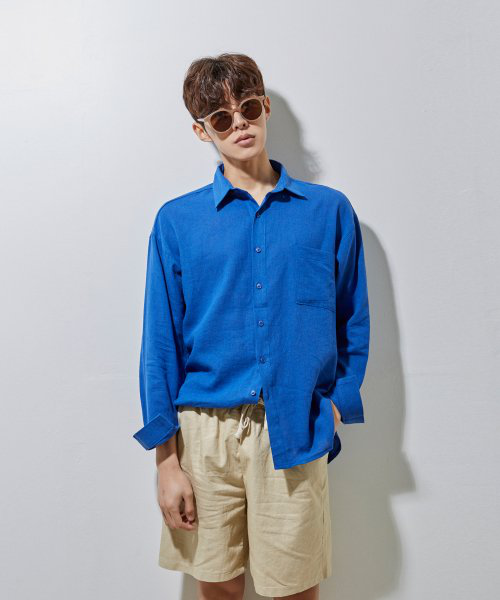

Processing 1 images
image                    shape: (600, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[0.98908883, 0.930919]

---------------------- segmentation된 사진 ----------------------
category : shorts



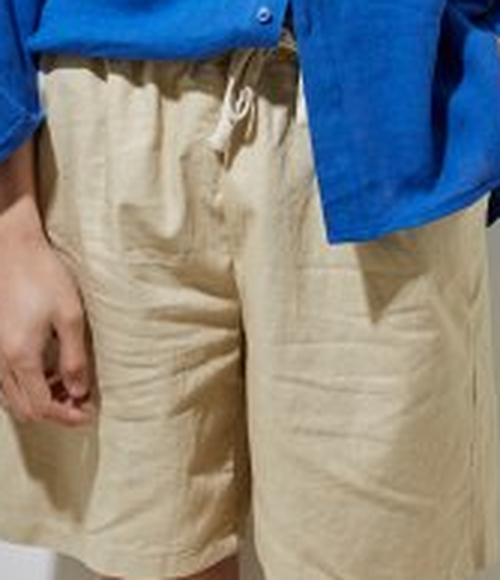

In [192]:
label, cropped_image = detection(list(uploaded.keys())[0])

### Codi recommendation

어서오세요! BITAmin 옷장에 오신걸 환영합니다😀
옷 사진을 첨부해주시면 이를 활용한 코디를 추천해드릴게요😉
되도록 상의, 하의, 아우터 등 한 부위만 찍힌 사진으로 첨부해주시면 더욱 정확도가 높은 코디를 추천받으실 수 있답니다!
저희 코디 데이터는 무신사를 기반으로 만들어졌습니다.
------------------------------------------------------------------------------------------------------------------------------------------------------------

어떤 스타일을 원하시나요? [캐주얼, 스트릿, 이지 캐주얼, 댄디, 포멀, 스포츠, 레트로, 걸리시, 스포츠 캐주얼, 세미 포멀, 캠퍼스, 시크, 골프, 로맨틱, 비즈니스] : 
캠퍼스

------------------------------------------------------------------------------------------------------------------------------------------------------------

짠~! 코디가 추천되었습니다👕👖



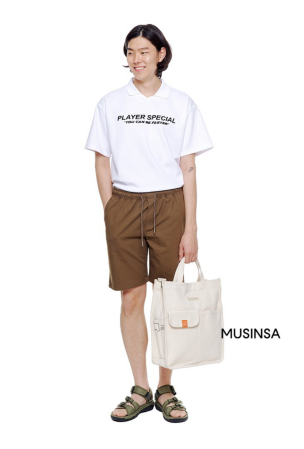


------------------------------------------------------------------------------------------------------------------------------------------------------------

✨이 코디에 사용된 세부 아이템입니다✨



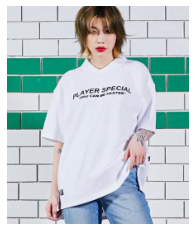

💙 Brand :  시디스콤마
🧡 상품명 :  플레이어 스페셜 PK T(WHITE)
💛 가격 :  49,000 원
💚 정확한 정보는 여기서 확인하세요>>>>> https://store.musinsa.com/app/goods/1000237/0



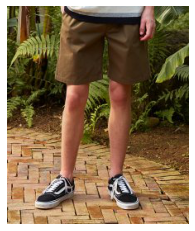

💙 Brand :  필루미네이트
🧡 상품명 :  유니섹스 스탠다드 트윌 숏츠-카키
💛 가격 :  36,000 원
💚 정확한 정보는 여기서 확인하세요>>>>> https://store.musinsa.com/app/goods/1003634/0



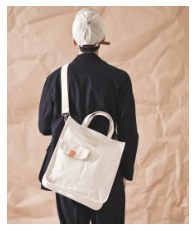

💙 Brand :  에이지 그레이
🧡 상품명 :  시그니쳐투웨이에코(에크루))
💛 가격 :  44,000 원
💚 정확한 정보는 여기서 확인하세요>>>>> https://store.musinsa.com/app/goods/993820/0



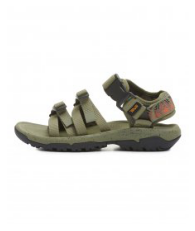

💙 Brand :  테바
🧡 상품명 :  맨즈 허리케인 XLT2 Alp / 1100033-BLKO
💛 가격 :  109,000 원
💚 정확한 정보는 여기서 확인하세요>>>>> https://store.musinsa.com/app/goods/1019275/0



In [194]:
final_codi(cropped_image, label)

In [136]:
sample = '/content/drive/MyDrive/Conference/crawling/samples/sample12.jpeg'

- /content/drive/MyDrive/Conference/crawling/samples/sample.jpg
- /content/drive/MyDrive/Conference/crawling/samples/sample7.jpeg (캐주얼, 스트릿, 이지 캐주얼)
- /content/drive/MyDrive/Conference/crawling/samples/sample9.jpeg (캐주얼)
- /content/drive/MyDrive/Conference/crawling/samples/sample12.jpeg (캐주얼, 캠퍼스)
- /content/drive/MyDrive/의류 추천 시스템/AI/test/빨간색 바지.jpg (스트릿)
- /content/drive/MyDrive/의류 추천 시스템/AI/test/초록색 바지.jpg (스트릿)
- '/content/drive/MyDrive/의류 추천 시스템/AI/test/셔츠.jpg' (댄디, 세미 포멀, 골프)